# Navigation Project Submission (Deep RL Course)

---
This notebook contains a submission for the Navigation Project from Udacity's DeepRL course.

### 1. Imports and definitions

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

**_Before running the cells below_**,  note that the `banana_app_file_name` parameter must match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
banana_app_file_name="Banana.app"
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [2]:
# IMPORTANT : ensure that path to the Banana app is correct for your environment!
banana_app_file_name="/Users/paulvarkey/Documents/Value-based-methods/p1_navigation/Banana.app"

In [3]:
class BananaDQN:

    """
    NOTE : call <BananaDQN object>.env.close() at the end of using this class!
    """

    def __init__(self, banana_app_file_name="Banana.app"):
        self.env = UnityEnvironment(banana_app_file_name)

        # Environments contain **_brains_** which are responsible for 
        # deciding the actions of their associated agents. Here we 
        # check for the first brain available, and set it as the 
        # default brain we will be controlling from Python.
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]

        # reset the environment
        env_info = self.env.reset(train_mode=True)[self.brain_name]

        # number of agents in the environment
        self.num_agents = len(env_info.agents)
        print('Number of agents:', self.num_agents)

        # number of actions
        self.action_size = self.brain.vector_action_space_size
        print('Number of actions:', self.action_size)

        # examine the state space 
        state = env_info.vector_observations[0]
        print('States look like:', state)
        self.state_size = len(state)
        print('States have length:', self.state_size)

        # create the DQN agent
        self.agent = Agent(
            state_size=self.state_size,
            action_size=self.action_size, 
            seed=0
        )

    def _step(self, action):
        """Given an action, produce next state, reward, and done indicator.
        
        Note that the current state itself is tracked implictly in the 
        state of the environment. It can be retrieved before taking this action : 
        ```
        env_info = self.env.step(action)[self.brain_name]
        state = env_info.vector_observations[0]
        ```
        """
        env_info = self.env.step(action)[self.brain_name]  # send the action to the environment
        next_state = env_info.vector_observations[0]       # get the next state
        reward = env_info.rewards[0]                       # get the reward
        done = env_info.local_done[0]                      # see if episode has finished
        return (next_state, reward, done)

    def _randomly_act(self):
        env_info = self.env.reset(train_mode=False)[self.brain_name] # reset the environment
        state = env_info.vector_observations[0]                      # get the current state
        score = 0                                                    # initialize the score
        while True:
            action = np.random.randint(self.action_size)    # select an action
            (next_state, reward, done) = self._step(action) # get (s,a) --> (s', r, done)
            score += reward                                 # update the score
            state = next_state                              # roll over the state to next time step
            if done:                                        # exit loop if episode finished
                break
            
        print("Score: {}".format(score))

    def dqn(
        self,
        n_episodes=2000,
        max_t=1000,
        eps_start=1.0,
        eps_end=0.01, 
        eps_decay=0.995,
        plot=False,
        save_if_avg100_score_greater_than=16.7,
    ):
        """Deep Q-Learning.
        
        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        """
        scores = []                        # list containing scores from each episode
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start                    # initialize epsilon

        for i_episode in range(1, n_episodes+1):
            # reset environment
            env_info = self.env.reset(train_mode=True)[self.brain_name]
            state = env_info.vector_observations[0] # get the current state

            score = 0
            for t in range(max_t):
                action = self.agent.act(state, eps)
                next_state, reward, done = self._step(action)
                self.agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break 

            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=save_if_avg100_score_greater_than:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(self.agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                break

        # optionally, plot the scores
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(len(scores)), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()

        return scores
    
    def viz_agent_load_trained_checkpoint(
        self,
        checkpoint_path = "checkpoint.pth",
        num_episodes = 10,
    ):
        # load the weights from file
        self.agent.qnetwork_local.load_state_dict(torch.load(checkpoint_path))

        episode_score_total = 0

        for e_idx in range(num_episodes):

            env_info = self.env.reset(train_mode=False)[self.brain_name] # reset the environment
            state = env_info.vector_observations[0]                      # get the current state

            score = 0
            step_idx = 0 
            while True:
                step_idx += 1
                action = self.agent.act(state)
                (next_state, reward, done) = self._step(action) # get (s,a) --> (s', r, done)
                score += reward                                 # update the score
                state = next_state                              # roll over the state to next time step
                if step_idx % 100 == 0:
                    print(f"step_idx={step_idx}, score={score}")
                if done:                                        # exit loop if episode finished
                    break
            
            episode_score_total += score
            print(f"Episode {e_idx + 1} Score: {score}")

        print(f"Average score across {num_episodes} episodes = {float(episode_score_total)/num_episodes}")

In [4]:
# IMPORTANT : ensure that path to the Banana app is correct for your environment!
banana_dqn = BananaDQN(banana_app_file_name=banana_app_file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 2. [Optional] Take Random Actions in the Environment

Watch the agent's performance, as it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.

In [ ]:
# banana_dqn._randomly_act()

### 3. [Optional] Train using DQN

If you choose to train, you may uncomment, and optionally choose to change the hyperparameters below. The default values are quite good already. You can also choose to change the `save_if_avg100_score_greater_than` parameter to ensure that checkpoints are written out, if the average score over the last 100 episodes is greater than the score attained by the model checkpointed into checkpoint.pth. The default corresponds to the best obtained with the default hyperparameters.

Episode 100	Average Score: 1.23
Episode 200	Average Score: 4.78
Episode 300	Average Score: 8.07
Episode 400	Average Score: 10.94
Episode 500	Average Score: 12.40
Episode 600	Average Score: 13.86
Episode 700	Average Score: 14.79
Episode 800	Average Score: 15.16
Episode 900	Average Score: 15.21
Episode 1000	Average Score: 15.53
Episode 1100	Average Score: 15.89
Episode 1146	Average Score: 16.57
Environment solved in 1046 episodes!	Average Score: 16.57


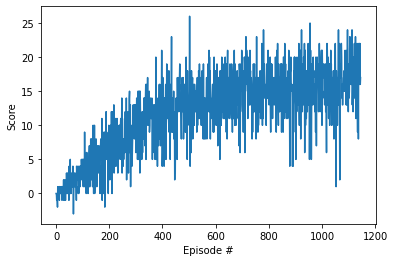

In [ ]:
# scores = banana_dqn.dqn(
#     n_episodes=2000,
#     max_t=1000,
#     eps_start=1.0,
#     eps_end=0.01, 
#     eps_decay=0.995,
#     plot=True,
#     save_if_avg100_score_greater_than=16.5,
# )

### 4. [Optional] Load checkpoint and visualize

In [6]:
banana_dqn.viz_agent_load_trained_checkpoint()

step_idx=100, score=7.0
step_idx=200, score=10.0
step_idx=300, score=18.0
Episode 1 Score: 18.0
step_idx=100, score=9.0
step_idx=200, score=14.0
step_idx=300, score=14.0
Episode 2 Score: 14.0
step_idx=100, score=4.0
step_idx=200, score=9.0
step_idx=300, score=13.0
Episode 3 Score: 13.0
step_idx=100, score=8.0
step_idx=200, score=15.0
step_idx=300, score=20.0
Episode 4 Score: 20.0
step_idx=100, score=7.0
step_idx=200, score=16.0
step_idx=300, score=20.0
Episode 5 Score: 20.0
step_idx=100, score=1.0
step_idx=200, score=1.0
step_idx=300, score=1.0
Episode 6 Score: 1.0
step_idx=100, score=4.0
step_idx=200, score=10.0
step_idx=300, score=17.0
Episode 7 Score: 17.0
step_idx=100, score=4.0
step_idx=200, score=8.0
step_idx=300, score=12.0
Episode 8 Score: 12.0
step_idx=100, score=4.0
step_idx=200, score=5.0
step_idx=300, score=15.0
Episode 9 Score: 15.0
step_idx=100, score=6.0
step_idx=200, score=12.0
step_idx=300, score=18.0
Episode 10 Score: 18.0
Average score across 10 episodes = 14.8


### Close the environment, when done!

When finished, you can close the environment.

In [7]:
banana_dqn.env.close()